# Introduction

The main aim of this project is to study in detail various regression methods,
including the Ordinary Least Squares (OLS) method, Ridge regression, and 
Lasso regression. These methods are in turn combined with resampling techniques like the
bootstrap method and cross validation. We will first study how to fit polynomials to a specific two-dimensional
function called Franke’s function. Furthermore,
after having established the model and the method, we will employ resamling
techniques such as cross-validation and/or bootstrap in order to perform a proper
assessment of our models. We will also study in detail the so-called Bias-Variance
trade off.

In [1]:
import os
import sys
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 
import numpy as np 
from random import random, seed
import functions as fx
import sklearn.model_selection as sklm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from imageio import imread

In [2]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "/Users/endriasa/Projects/FYS4155/Project-1/Figures"
FIGURE_ID = "Figures"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", dpi=100,pad_inches=0.0,transparent=False, bbox_inches='tight',format='png')

# Franke function and digital tarrain data

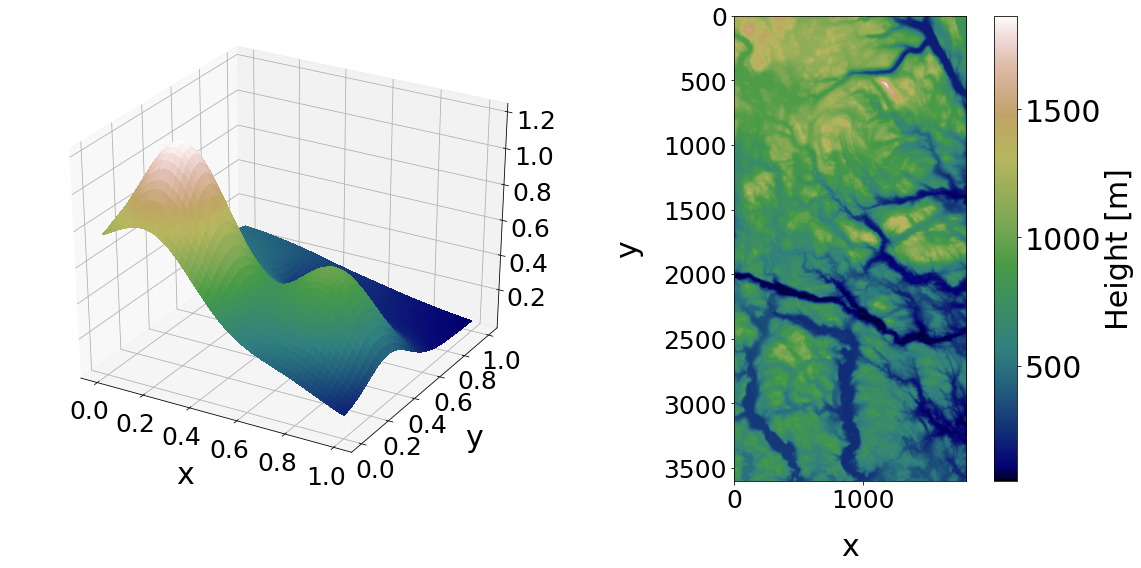

In [109]:
# Make data using rand function
n_x = 100
x   = np.sort(np.random.uniform(0, 1, n_x))
y   = np.sort(np.random.uniform(0, 1, n_x))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
noise_sigma = 0.00
zz          = fx.FrankeFunction(xx, yy, noise_sigma)
z           = np.ravel(zz)

# Load the terrain
terrain_data = imread('SRTM_data_Norway_1.tif')
nxt,nyt      = terrain_data.shape
xt           = np.linspace(0, 1, nxt)
yt           = np.linspace(0, 1, nyt)
xi           = np.linspace(0,1,int(nxt*5))
yi           = np.linspace(0,1,int(nyt*5))
xxt, yyt     = np.meshgrid(xt,yt)
xxi, yyi     = np.meshgrid(xi,yi)
zi           = terrain_data #interpolate.interp2d(xt, yt, terrain_data.T, kind='cubic')


# Plot the surfaces
fig  = plt.figure(figsize=(16, 8))
ax   = fig.add_subplot(1, 2, 1,projection='3d')
surf = ax.plot_surface(xx, yy, zz, cmap='gist_earth',antialiased=False)
#ax.set_zlim3d(np.min(zz), np.max(zz))
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.tick_params(axis='x', which='major', labelsize=25,pad=5)
ax.tick_params(axis='y', which='major', labelsize=25,pad=5)
ax.tick_params(axis='z', which='major', labelsize=25,pad=10)
plt.xlabel('x', fontsize = 30,labelpad=25)
plt.ylabel('y', fontsize = 30,labelpad=25)
#cbar=fig.colorbar(surf,orientation="vertical", pad=0.2)
#cbar.ax.tick_params(labelsize=30)
fig.tight_layout()

# Show the terrain
ax   = fig.add_subplot(1, 2, 2)
surf = ax.imshow(zi, cmap='gist_earth')
#ax.set_zlim3d(np.min(terrain_data.T)-1e2, np.max(terrain_data.T)+1e3)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('x', fontsize = 30,labelpad=20)
plt.ylabel('y', fontsize = 30,labelpad=20)
cbar=fig.colorbar(surf)
cbar.ax.set_ylabel('Height [m]', fontsize = 30)
cbar.ax.tick_params(labelsize=30)
fig.tight_layout()
save_fig('Input_data')
plt.show()


## Ordinary Least Square (OLS) on the Franke function

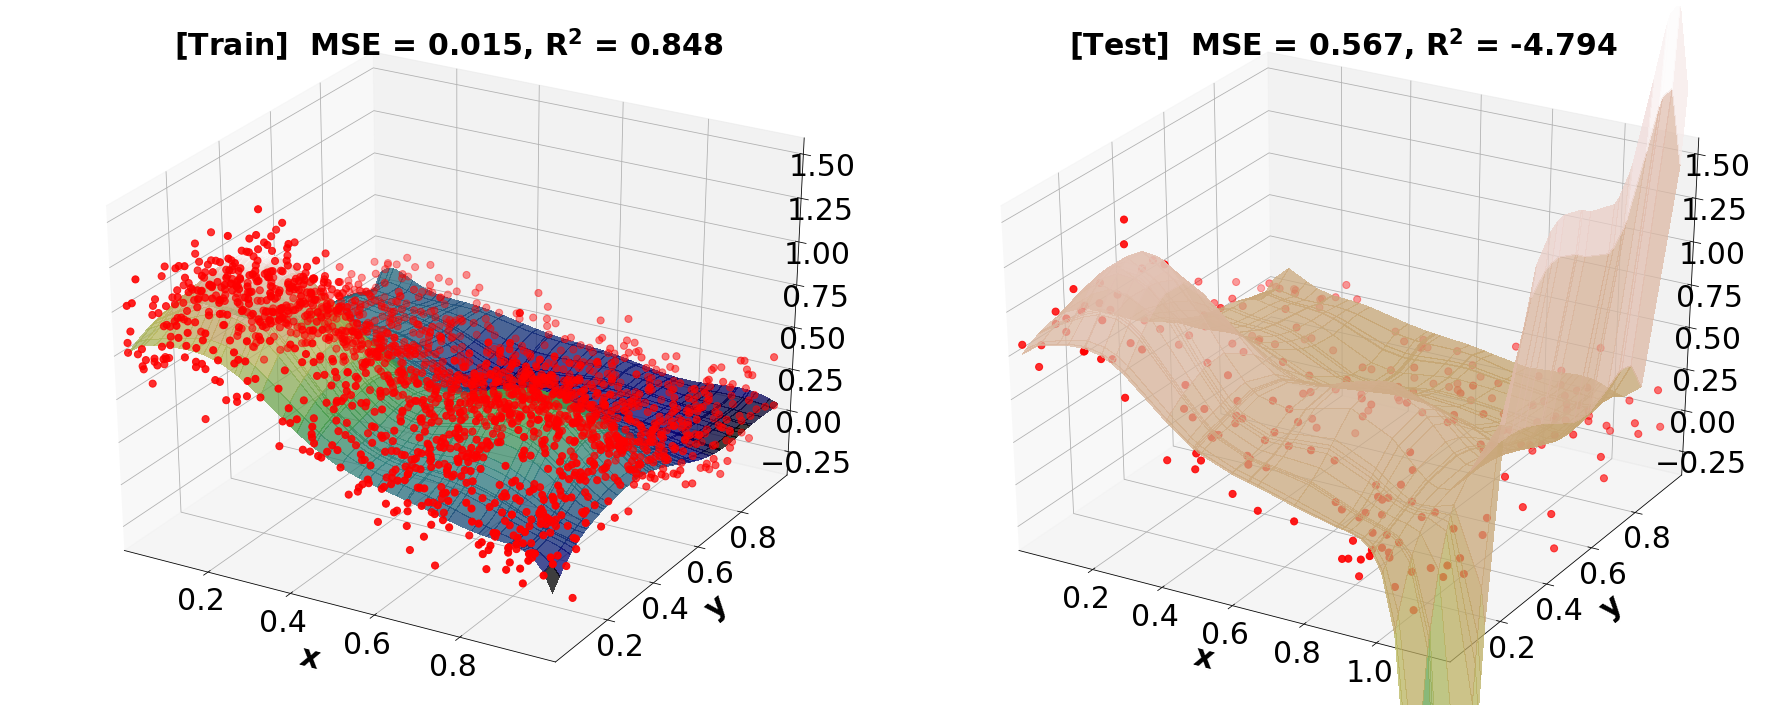

In [15]:
# Maximum polynomial order for generating the design matrix
degree    = 10                
l         = int((degree+1)*(degree+2)/2)
n_samp    = int((2*l)/0.8)
np.random.seed(2020)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1.2, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)  

## Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]
    
# OLS (Training) 
beta_OLS, pred_OLS_test, pred_OLS_train = fx.OridinaryLeastSquares(X_train,z_train,X_test) 

#sklearn OLS
#OLS = LinearRegression(normalize=True,fit_intercept=False)
#OLS.fit(X_train, z_train)
#pred_OLS_test  = OLS.predict(X_test)
#pred_OLS_train = OLS.predict(X_train)
#beta_OLS       = OLS.coef_

# MSE and R2
MSE_OLS_test  = fx.MSE(z_test,pred_OLS_test)
MSE_OLS_train = fx.MSE(z_train,pred_OLS_train)
R2_OLS_test   = fx.R2Score(z_test,pred_OLS_test)
R2_OLS_train  = fx.R2Score(z_train,pred_OLS_train)
        
# Plot the resulting fit beside the original surface
ppred_OLS_test  = pred_OLS_test.reshape(xx_test.shape)
ppred_OLS_train = pred_OLS_train.reshape(xx_train.shape)

#---------------------------------------------------------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
CS=ax.plot_surface(xx_train, yy_train, ppred_OLS_train, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
figure1=ax.scatter(xx_train[0::10], yy_train[0::10], zz_train[0::10], 
           marker='.', s=200, c="red")
ax.set_zlim3d(np.min(z_train), np.max(z_train))
ax.set_ylim3d(np.min(y_train), np.max(y_train))
ax.set_xlim3d(np.min(x_train), np.max(x_train))
#cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
#cbar.ax.set_ylabel('Franke Function', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Train] " + " MSE = %0.3f" %MSE_OLS_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_train, fontsize = 30, fontweight='bold')
fig.tight_layout()

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.set_zlim3d(np.min(z_train), np.max(z_train))
ax1.set_ylim3d(np.min(y_test), np.max(y_test))
ax1.set_xlim3d(np.min(x_test), np.max(x_test))
CS=ax1.plot_surface(xx_test, yy_test, ppred_OLS_test, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
ax1.scatter(xx_test[0::5], yy_test[0::5], zz_test[0::5], 
           marker='.', s=200, c="red")
#cbar1 = fig.colorbar(surf, shrink=0.5, aspect=10)
#cbar1.ax1.set_ylabel('Franke Function', fontsize = 22)
ax1.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
#plt.title("[Test] " + r"$\bf{\sigma}$ = %0.1f"%nsig + ", MSE = %0.3f" %MSE_OLS_test + 
#          r", $\bf{R^2}$ = %0.3f"%R2_OLS_test, fontsize = 30, fontweight='bold')
plt.title("[Test] " + " MSE = %0.3f" %MSE_OLS_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_test, fontsize = 30, fontweight='bold')
fig.tight_layout()
save_fig('Noisy_OLS_degree10')
plt.show()

# Ridge Regression on the Franke function

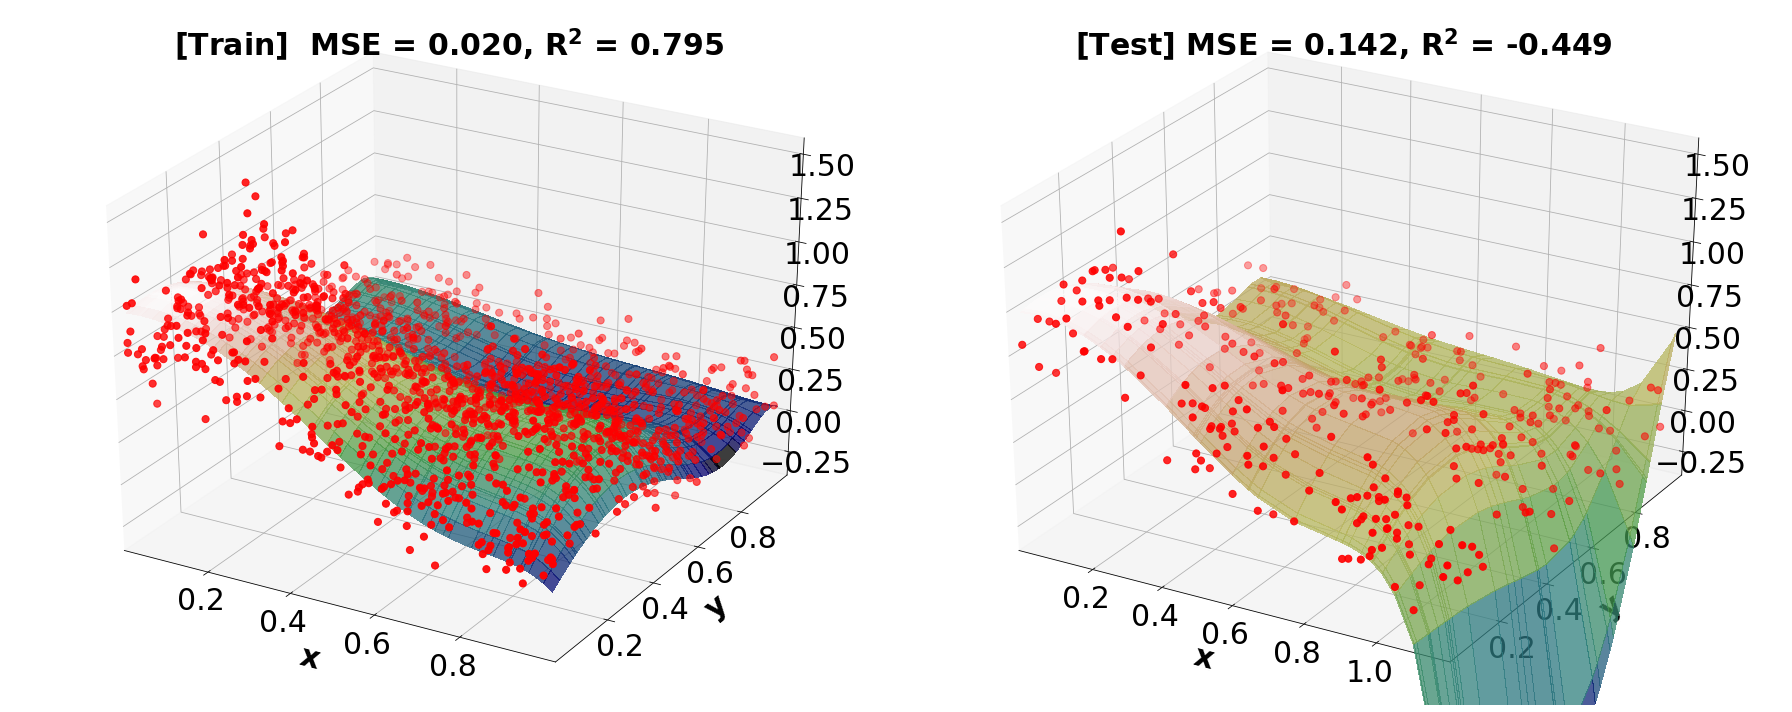

In [51]:
# Maximum polynomial order for generating the design matrix
degree    = 10                
l         = int((degree+1)*(degree+2)/2)
n_samp    = int((2*l)/0.8)
np.random.seed(2020)
x       = (np.random.uniform(0, 1, n_samp))
y       = (np.random.uniform(0, 1, n_samp))
x1      = (np.random.uniform(0, 1.2, n_samp))
y1      = (np.random.uniform(0, 1, n_samp))
_lambda = 1e1

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)  

## Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# Ridge (Training) 
beta_Ridge, pred_Ridge_test, pred_Ridge_train = fx.RidgeRegression(X_train,z_train,X_test,_lambda)

#sklearn Ridge
#ridgereg = Ridge(alpha=_lambda, normalize=False)
#ridgereg.fit(X_train, z_train)
#pred_Ridge_test  = ridgereg.predict(X_test)
#pred_Ridge_train = ridgereg.predict(X_train)
#beta_Ridge       = ridgereg.coef_

# MSE and R2
MSE_Ridge_test  = fx.MSE(z_test,pred_Ridge_test)
MSE_Ridge_train = fx.MSE(z_train,pred_Ridge_train)
R2_Ridge_test   = fx.R2Score(z_test,pred_Ridge_test)
R2_Ridge_train  = fx.R2Score(z_train,pred_Ridge_train)
        
# Plot the resulting fit beside the original surface
ppred_Ridge_test  = pred_Ridge_test.reshape(xx_test.shape)
ppred_Ridge_train = pred_Ridge_train.reshape(xx_train.shape)

#---------------------------------------------------------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
CS=ax.plot_surface(xx_train, yy_train, ppred_Ridge_train, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
figure1=ax.scatter(xx_train[0::int(n_train*0.1)], yy_train[0::int(n_train*0.1)], zz_train[0::int(n_train*0.1)], 
           marker='.', s=200, c="red")
ax.set_zlim3d(np.min(z_train), np.max(z_train))
ax.set_ylim3d(np.min(y_train), np.max(y_train))
ax.set_xlim3d(np.min(x_train), np.max(x_train))
#cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
#cbar.ax.set_ylabel('Franke Function', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Train] " + " MSE = %0.3f" %MSE_Ridge_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_train, fontsize = 30, fontweight='bold')
fig.tight_layout()

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.set_zlim3d(np.min(z_train), np.max(z_train))
ax1.set_ylim3d(np.min(y_test), np.max(y_test))
ax1.set_xlim3d(np.min(x_test), np.max(x_test))
CS=ax1.plot_surface(xx_test, yy_test, ppred_Ridge_test, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
ax1.scatter(xx_test[0::int(n_test*0.1)], yy_test[0::int(n_test*0.1)], zz_test[0::int(n_test*0.1)], 
           marker='.', s=200, c="red")
#cbar1 = fig.colorbar(surf, shrink=0.5, aspect=10)
#cbar1.ax1.set_ylabel('Franke Function', fontsize = 22)
ax1.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Test] " + "MSE = %0.3f" %MSE_Ridge_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_test, fontsize = 30, fontweight='bold')
fig.tight_layout()
save_fig('Noisy_Ridge_degree10')
plt.show()

# LASSO Regression on the Franke function

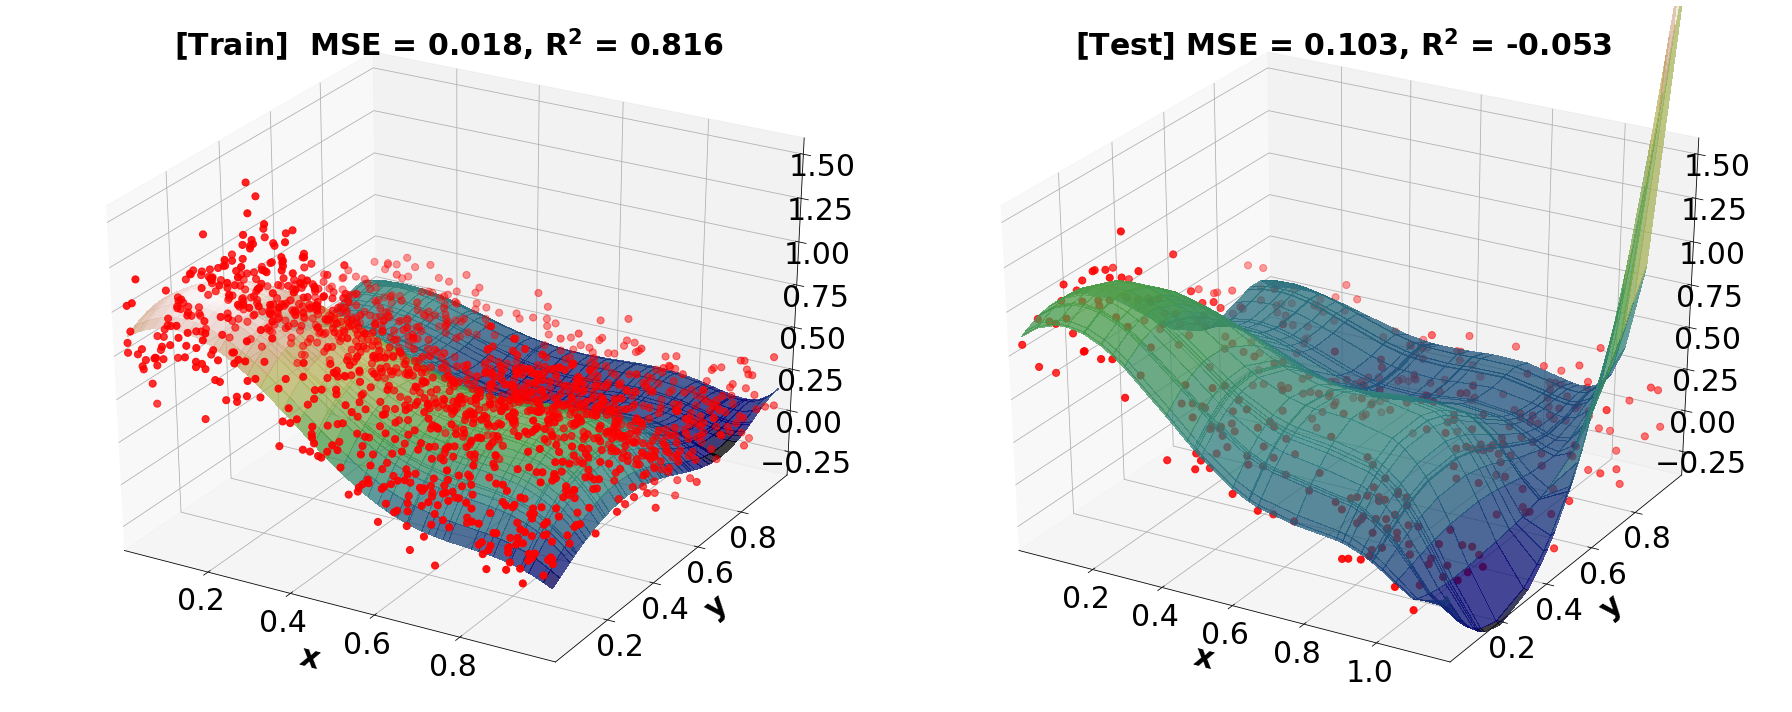

In [46]:
# Maximum polynomial order for generating the design matrix
degree    = 10                
l         = int((degree+1)*(degree+2)/2)
n_samp    = int((2*l)/0.8)
np.random.seed(2020)
x       = (np.random.uniform(0, 1, n_samp))
y       = (np.random.uniform(0, 1, n_samp))
x1      = (np.random.uniform(0, 1.2, n_samp))
y1      = (np.random.uniform(0, 1, n_samp))
_lambda = 1e-4

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)  

## Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]
    
# LASSO (Training) 
lasso      = Lasso(alpha = _lambda, max_iter=10e5,fit_intercept=True, tol=1e-6)
clf_lasso  = lasso.fit(X_train, z_train) 
beta_LASSO = clf_lasso.coef_
beta_LASSO = beta_LASSO.reshape(X_train.shape[1],1)

pred_LASSO_test  = lasso.predict(X_test)
pred_LASSO_train = lasso.predict(X_train)
    
# MSE and R2
MSE_LASSO_test  = fx.MSE(z_test,pred_LASSO_test)
MSE_LASSO_train = fx.MSE(z_train,pred_LASSO_train)
R2_LASSO_test   = fx.R2Score(z_test,pred_LASSO_test)
R2_LASSO_train  = fx.R2Score(z_train,pred_LASSO_train)
        
# Plot the resulting fit beside the original surface
ppred_LASSO_test  = pred_LASSO_test.reshape(xx_test.shape)
ppred_LASSO_train = pred_LASSO_train.reshape(xx_train.shape)

#---------------------------------------------------------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
CS=ax.plot_surface(xx_train, yy_train, ppred_LASSO_train, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
figure1=ax.scatter(xx_train[0::int(n_train*0.1)], yy_train[0::int(n_train*0.1)], zz_train[0::int(n_train*0.1)], 
           marker='.', s=200, c="red")
ax.set_zlim3d(np.min(z_train), np.max(z_train))
ax.set_ylim3d(np.min(y_train), np.max(y_train))
ax.set_xlim3d(np.min(x_train), np.max(x_train))
#cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
#cbar.ax.set_ylabel('Franke Function', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Train] " + " MSE = %0.3f" %MSE_LASSO_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_train, fontsize = 30, fontweight='bold')
fig.tight_layout()

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.set_zlim3d(np.min(z_train), np.max(z_train))
ax1.set_ylim3d(np.min(y_test), np.max(y_test))
ax1.set_xlim3d(np.min(x_test), np.max(x_test))
CS=ax1.plot_surface(xx_test, yy_test, ppred_LASSO_test, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
ax1.scatter(xx_test[0::int(n_test*0.1)], yy_test[0::int(n_test*0.1)], zz_test[0::int(n_test*0.1)], 
           marker='.', s=200, c="red")
#cbar1 = fig.colorbar(surf, shrink=0.5, aspect=10)
#cbar1.ax1.set_ylabel('Franke Function', fontsize = 22)
ax1.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Test] " + "MSE = %0.3f" %MSE_LASSO_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_test, fontsize = 30, fontweight='bold')
fig.tight_layout()
save_fig('Noisy_LASSO_degree10')
plt.show()

# Bias-variance trade-off (OLS)

1130


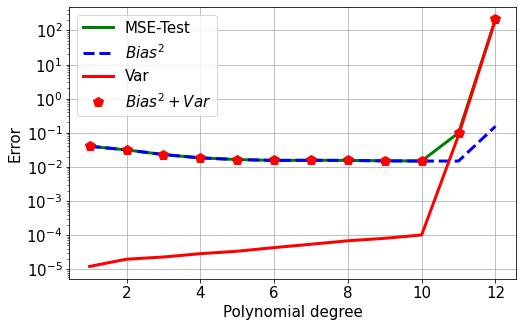

In [65]:
# Maximum polynomial order for generating the design matrix
maxdegree = 12               # try it with 15
maxind    = int(maxdegree*1) 
l         = int((maxind+1)*(maxind+2)/2)
n_samp    = int((1*l)/0.8)

# Make data using rand function
np.random.seed(2020)
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
zz_0 = fx.FrankeFunction(xx, yy, 0)
nsig = 0.1*np.max(np.abs(zz_0))
zz   = fx.FrankeFunction(xx, yy, nsig)
z    = np.ravel(zz)

n_boostraps = int(10*n_samp)                                  # put it to 20
print(n_boostraps)
degrees     = np.arange(1,maxdegree+1)

# Pre-allocate 
err1   = []
errt1  = []
bi1    = []
vari1  = []
scaler = StandardScaler()

# Running loop over model complexity 
for i in range(maxdegree):
    
    # Creating design matrix
    X = fx.DesignDesign(x,y,i+1)  

    # split in training and test data
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    
    # Scaling
    X_test_int  = X_test[:,0]
    X_test      = X_test[:,1:]

    z_test   = z_test.reshape(z_test.shape[0],1)
    z_pred   = np.empty((z_test.shape[0], n_boostraps))
    z_predt  = np.empty((z_train.shape[0], n_boostraps))
    z_train2 = np.empty((z_train.shape[0], n_boostraps))
    
    for i in range(n_boostraps):
        X_, z_         = resample(X_train, z_train)
        z_train2[:, i] = z_
        
        # Scaling
        X_int = X_[:,0]
        X_    = X_[:,1:]
        scaler.fit(X_)
        X_      = scaler.transform(X_)
        X_test2 = scaler.transform(X_test)
        X_      = np.c_[X_int,X_]
        X_test2 = np.c_[X_test_int,X_test2]
        
        # Evaluate the new model on the same test data each time.
        _, z_pred[:, i], z_predt[:, i] = fx.OridinaryLeastSquares(X_,z_,X_test2)
    
    errorin  = np.mean(np.mean((z_train2 - z_predt)**2, axis=1, keepdims=True))
    error    = np.mean(np.mean((z_test - z_pred)**2, axis=1, keepdims=True))
    bias     = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance = np.mean(np.var(z_pred, axis=1, keepdims=True))
    
    err1.append(error)
    errt1.append(errorin)
    bi1.append(bias)
    vari1.append(variance)

fig, ax = plt.subplots(figsize=(8,5))   
plt.semilogy(degrees[:maxdegree],err1[:maxdegree],'g',linewidth=3,label='MSE-Test')
#plt.semilogy(degrees[:maxdegree],errt1[:maxdegree],'k--',linewidth=3,label='MSE-Train')
plt.semilogy(degrees[:maxdegree],bi1[:maxdegree],'--b',linewidth=3,label='$Bias^2$')
plt.semilogy(degrees[:maxdegree],vari1[:maxdegree],'-r',linewidth=3,label='Var')
summ1 = np.zeros(len(vari1))
for i in range(len(err1)):
    summ1[i] = vari1[i] + bi1[i]    
plt.semilogy(degrees[:maxdegree],summ1[:maxdegree],'rp',label='$Bias^2 + Var$',markersize=10)
#ax.set_ylim(1e-3, 1)
plt.xlabel('Polynomial degree', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='upper left',fontsize=15)
save_fig('Bias_varience_OLS')
plt.show()

# In-sample and out-off-sample errors as a function of training size (OLS)

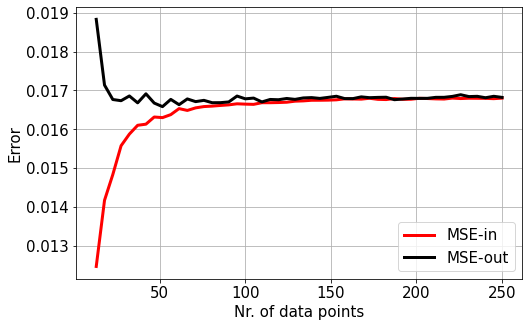

In [61]:
# Maximum polynomial order for generating the design matrix
maxdegree = 5               
l         = int((maxdegree+1)*(maxdegree+2)/2)
n_samp    = int((0.5*l)/0.8)

# Number of samples
N     = np.linspace(n_samp,250,50)
Ndiv  = 100

# Make data using rand function
np.random.seed(2020)
scaler = StandardScaler()

# Pre-allocate 
mse_in  = np.empty(len(N))
mse_out = np.empty(len(N))
J       = 0

for ii in N:

    errinx  = 0
    erroutx = 0
    
    for mm in range(Ndiv):
        
        np.random.seed(2020+mm)
        x = np.sort(np.random.uniform(0, 1, int(ii)))
        y = np.sort(np.random.uniform(0, 1, int(ii)))
        xx, yy = np.meshgrid(x,y)

        # Generate noise and add it to Franke function
        zz_0 = fx.FrankeFunction(xx, yy, 0)
        nsig = 0.1*np.max(np.abs(zz_0))
        zz   = fx.FrankeFunction(xx, yy, nsig)
        z    = np.ravel(zz)

        # Creating design matrix
        X = fx.DesignDesign(x,y,maxdegree)  
        x_train, x_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
        
        # Scaling
        x_train_int = x_train[:,0]
        x_test_int  = x_test[:,0]
        x_train     = x_train[:,1:]
        x_test      = x_test[:,1:]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test  = scaler.transform(x_test)
        x_train = np.c_[x_train_int,x_train]
        x_test  = np.c_[x_test_int,x_test]
        
        # OLS
        _, predict, predict_train = fx.OridinaryLeastSquares(x_train,z_train,x_test)
    
        errin  = fx.MSE(z_train, predict_train)
        errout = fx.MSE(z_test, predict)
            
        errinx  += errin
        erroutx += errout
    
    mse_in[J]  = errinx/Ndiv
    mse_out[J] = erroutx/Ndiv
    J          += 1
    
# ----------------------------- Plotting ---------------------

fig, ax = plt.subplots(figsize=(8,5))   
plt.plot(N,mse_in,'r',linewidth=3,label='MSE-in')
plt.plot(N,mse_out,'k',linewidth=3,label='MSE-out')
plt.xlabel('Nr. of data points', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='lower right',fontsize=15)
save_fig('Bias_varience_OLS_Nsamp')
plt.show()

# Model Selection by K-fold Cross Validation (OLS)

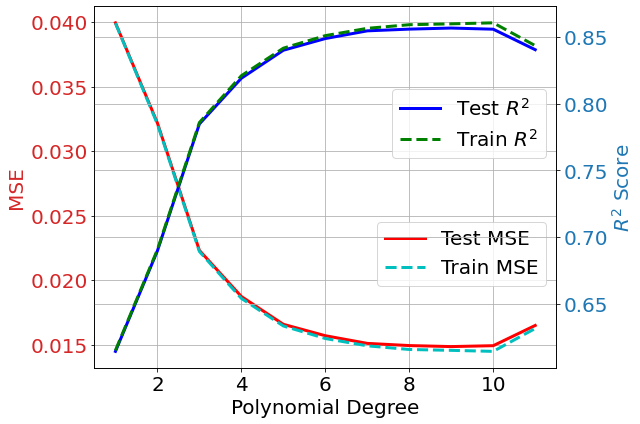

In [66]:
# Maximum polynomial order and K-fold
maxpower = 11
k        = 5

# Generate uniformly random data points
np.random.seed(2020)
n_samp = 1*int((maxpower+1)*(maxpower+2)/2)  
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
zz_0 = fx.FrankeFunction(xx, yy, 0)
nsig = 0.1*np.max(np.abs(zz_0))
zz   = fx.FrankeFunction(xx, yy, nsig)
z    = np.ravel(zz)

# pre-allocate 
r2_out_ols   = np.zeros(maxpower)
r2_in_ols    = np.zeros(maxpower)
mse_out_ols  = np.zeros(maxpower)
mse_in_ols   = np.zeros(maxpower)
scaler       = StandardScaler()

for i in range(maxpower):
    
    X = fx.DesignDesign(x,y,i+1)
    
    ## Scaling
    X_int = X[:,0]
    X     = X[:,1:]
    scaler.fit(X)
    X = scaler.transform(X)
    X = np.c_[X_int,X]
    
    r2_out_ols[i], mse_out_ols[i], r2_in_ols[i], mse_in_ols[i] \
                    = fx.k_fold_cv(k, z, X, fx.OridinaryLeastSquares, shuffle=True)

# ----------------------------- Plotting ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(9,6))
color    = 'tab:red'
ax1.set_xlabel('Polynomial Degree',fontsize=20)
ax1.set_ylabel('MSE',fontsize=20, color=color)
ax1.plot(range(1,maxpower+1), (mse_out_ols), 'r',linewidth=3, label='Test MSE')
ax1.plot(range(1,maxpower+1), (mse_in_ols), 'c',linewidth=3,linestyle='--', label='Train MSE')
ax1.legend(loc='lower right', bbox_to_anchor=(1, 0.2),fontsize=20)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.grid()

ax2   = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('$R^2$ Score',fontsize=20, color=color) 
ax2.plot(range(1,maxpower+1), (r2_out_ols),'b',linewidth=3, label=r'Test $R^2$')
ax2.plot(range(1,maxpower+1), (r2_in_ols),'g',linewidth=3, linestyle='--',label=r'Train $R^2$')
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.8),fontsize=20)
plt.grid()
fig.tight_layout()   
save_fig('Modelsel_OLS')
plt.show()

 # Model Selection by K-fold Cross Validation (Ridge and LASSO)

In [ ]:
# Maximum polynomial order for generating the design matrix
maxpower = 11
k        = 5

# Make data using rand function
np.random.seed(2020)
n_samp = 1*int((maxpower+1)*(maxpower+2)/2)   
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
zz_0 = fx.FrankeFunction(xx, yy, 0)
nsig = 0.1*np.max(np.abs(zz_0))
zz   = fx.FrankeFunction(xx, yy, nsig)
z    = np.ravel(zz)

lambdas = np.logspace(-6,-3,4)  # try it wit (-8,-2,7)
kfold   = KFold(n_splits = k,shuffle=True,random_state=5)
scaler  = StandardScaler()

mse_ridge_in  = np.empty([maxpower, len(lambdas)])
mse_ridge_out = np.empty([maxpower, len(lambdas)])
mse_lasso_in  = np.empty([maxpower, len(lambdas)])
mse_lasso_out = np.empty([maxpower, len(lambdas)])

for power in range(maxpower):
    for lamb in range(len(lambdas)): 
        X            = fx.DesignDesign(x,y,power+1)
        errin_lasso  = 0
        errout_lasso = 0
        errin_ridge  = 0
        errout_ridge = 0

        for train, test in kfold.split(X):
            x_train = X[train]
            z_train = z[train]
            x_test  = X[test]
            z_test  = z[test]

            ## Scaling
            x_train_int = x_train[:,0]
            x_test_int  = x_test[:,0]
            x_train     = x_train[:,1:]
            x_test      = x_test[:,1:]
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test  = scaler.transform(x_test)
            x_train = np.c_[x_train_int,x_train]
            x_test  = np.c_[x_test_int,x_test]

            lasso     = Lasso(alpha=lambdas[lamb], fit_intercept=True, max_iter=10e7) # try it with 10e7
            fit_lasso = lasso.fit(x_train, z_train)
            _, predictRidge, predictRidge_train = fx.RidgeRegression(x_train,z_train,x_test,lambdas[lamb])
            
            predictLasso       = lasso.predict(x_test)
            predictLasso_train = lasso.predict(x_train)
            
            errin_lasso  += fx.MSE(z_train, predictLasso_train)
            errout_lasso += fx.MSE(z_test, predictLasso)
            errin_ridge  += fx.MSE(z_train, predictRidge_train)
            errout_ridge += fx.MSE(z_test, predictRidge)
            
        mse_lasso_in[power,lamb]  = errin_lasso/k
        mse_lasso_out[power,lamb] = errout_lasso/k
        mse_ridge_in[power,lamb]  = errin_ridge/k
        mse_ridge_out[power,lamb] = errout_ridge/k

fig = plt.subplots(figsize=(30,10))
ax = plt.subplot(1, 2, 1)
for i in range(np.shape(lambdas)[0]):
    pl=ax.plot(range(1,maxpower+1),mse_ridge_out[:,i], label='$\lambda_{Ridge}$ ='+str(lambdas[i]),linewidth=3)
    col=pl[0].get_color()   
plt.legend()
ax.legend(loc='lower left',fontsize=30)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel('Polynomial Degree', fontsize=30)
plt.ylabel('Test MSE', fontsize=30)


ax = plt.subplot(1, 2, 2)
for i in range(np.shape(lambdas)[0]):
    pl=ax.plot(range(1,maxpower+1),mse_lasso_out[:,i], label='$\lambda_{LASSO}$ ='+str(lambdas[i]),linestyle='-',linewidth=3)
    col=pl[0].get_color()
plt.legend()
ax.legend(loc='upper right',fontsize=30)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel('Polynomial Degree', fontsize=30)
plt.ylabel('Test MSE', fontsize=30)
save_fig('Modelsel_Ridge_LASSO_scaled')
plt.show()


# Model Selection by K-fold Cross Validation (Ridge)

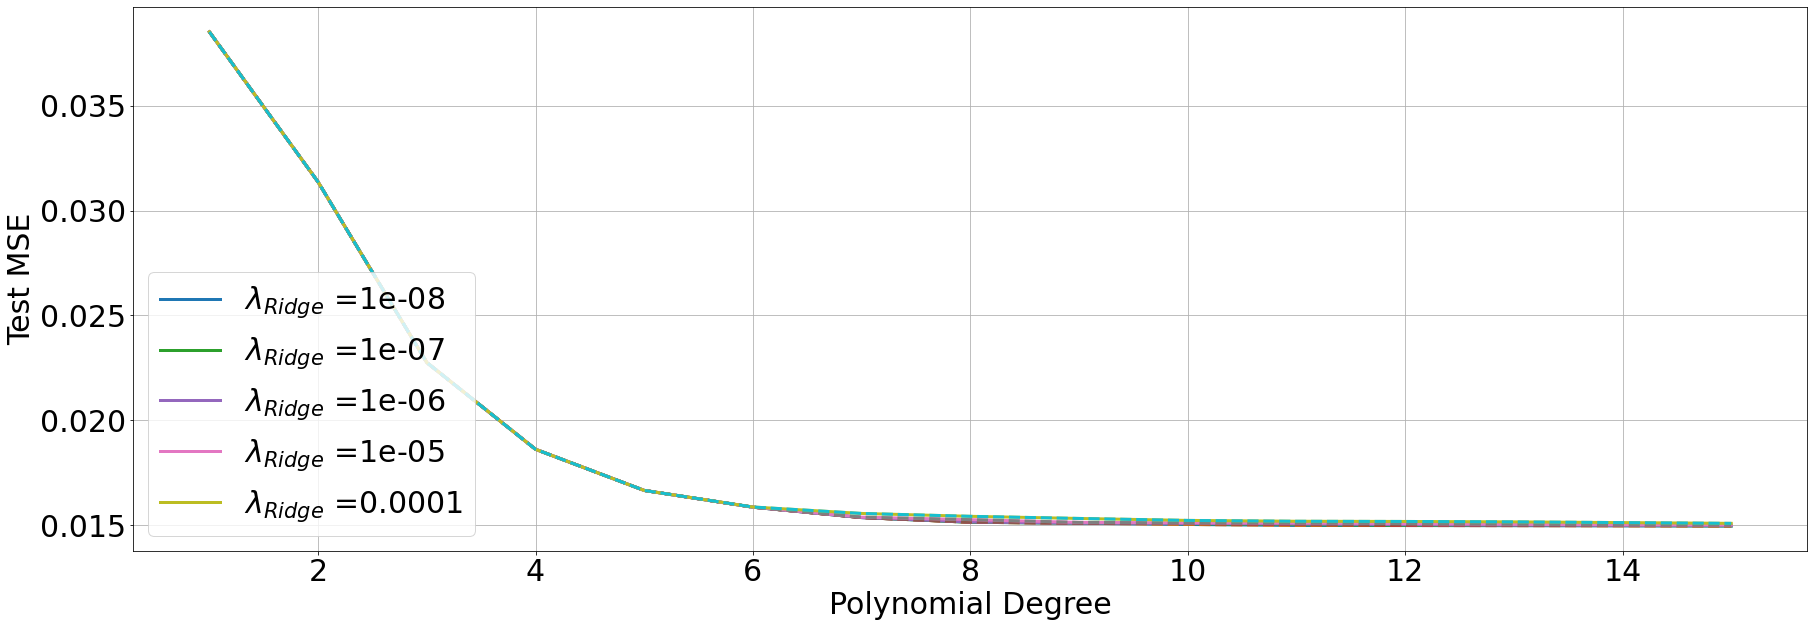

In [6]:
# Maximum polynomial order for generating the design matrix
maxpower = 15
k        = 5

# Make data using rand function
np.random.seed(2020)
n_samp = 1*int((maxpower+1)*(maxpower+2)/2)   
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
zz_0 = fx.FrankeFunction(xx, yy, 0)
nsig = 0.1*np.max(np.abs(zz_0))
zz   = fx.FrankeFunction(xx, yy, nsig)
z    = np.ravel(zz)

lambdas = np.logspace(-8,-4,5)  
kfold   = KFold(n_splits = k,shuffle=True,random_state=5)
scaler  = StandardScaler()

mse_ridge_in  = np.empty([maxpower, len(lambdas)])
mse_ridge_out = np.empty([maxpower, len(lambdas)])

for power in range(maxpower):
    for lamb in range(len(lambdas)): 
        X            = fx.DesignDesign(x,y,power+1)
        errin_ridge  = 0
        errout_ridge = 0

        for train, test in kfold.split(X):
            x_train = X[train]
            z_train = z[train]
            x_test  = X[test]
            z_test  = z[test]

            ## Scaling
            x_train_int = x_train[:,0]
            x_test_int  = x_test[:,0]
            x_train     = x_train[:,1:]
            x_test      = x_test[:,1:]
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test  = scaler.transform(x_test)
            x_train = np.c_[x_train_int,x_train]
            x_test  = np.c_[x_test_int,x_test]

            _, predictRidge, predictRidge_train = fx.RidgeRegression(x_train,z_train,x_test,lambdas[lamb])

            errin_ridge  += fx.MSE(z_train, predictRidge_train)
            errout_ridge += fx.MSE(z_test, predictRidge)

        mse_ridge_in[power,lamb]  = errin_ridge/k
        mse_ridge_out[power,lamb] = errout_ridge/k

fig, ax= plt.subplots(figsize=(30,10))
for i in range(np.shape(lambdas)[0]):
    pl=ax.plot(range(1,maxpower+1),mse_ridge_out[:,i], label='$\lambda_{Ridge}$ ='+str(lambdas[i]),linewidth=3)
    col=pl[0].get_color()   
    p2=ax.plot(range(1,maxpower+1),mse_ridge_out[:,i],linewidth=3,linestyle='--')
    col=p2[0].get_color()
plt.legend()
ax.legend(loc='lower left',fontsize=30)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel('Polynomial Degree', fontsize=30)
plt.ylabel('Test MSE', fontsize=30)
save_fig('Modelsel_Ridge')
plt.show()


 # Model Selection by K-fold Cross Validation (LASSO)

In [13]:
# Maximum polynomial order for generating the design matrix
maxpower = 10
k        = 5

# Make data using rand function
np.random.seed(2020)
n_samp = 1*int((maxpower+1)*(maxpower+2)/2)   
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
zz_0 = fx.FrankeFunction(xx, yy, 0)
nsig = 0.1*np.max(np.abs(zz_0))
zz   = fx.FrankeFunction(xx, yy, nsig)
z    = np.ravel(zz)

lambdas = np.logspace(-6,-6,1)  
kfold   = KFold(n_splits = k,shuffle=True,random_state=5)
scaler  = StandardScaler()

mse_lasso_in  = np.empty([maxpower, len(lambdas)])
mse_lasso_out = np.empty([maxpower, len(lambdas)])

for power in range(maxpower):
    for lamb in range(len(lambdas)): 
        X            = fx.DesignDesign(x,y,power+1)
        errin_lasso  = 0
        errout_lasso = 0
        errin_ridge  = 0
        errout_ridge = 0

        for train, test in kfold.split(X):
            x_train = X[train]
            z_train = z[train]
            x_test  = X[test]
            z_test  = z[test]

            ## Scaling
            x_train_int = x_train[:,0]
            x_test_int  = x_test[:,0]
            x_train     = x_train[:,1:]
            x_test      = x_test[:,1:]
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test  = scaler.transform(x_test)
            x_train = np.c_[x_train_int,x_train]
            x_test  = np.c_[x_test_int,x_test]

            lasso     = Lasso(alpha=lambdas[lamb], fit_intercept=False, max_iter=10e5, tol=1e-3) # try it with 10e7
            fit_lasso = lasso.fit(x_train, z_train)
           
            predictLasso       = lasso.predict(x_test)
            predictLasso_train = lasso.predict(x_train)
            
            errin_lasso  += fx.MSE(z_train, predictLasso_train)
            errout_lasso += fx.MSE(z_test, predictLasso)
            
        mse_lasso_in[power,lamb]  = errin_lasso/k
        mse_lasso_out[power,lamb] = errout_lasso/k

fig,ax = plt.subplots(figsize=(30,10))
for i in range(np.shape(lambdas)[0]):
    pl=ax.plot(range(1,maxpower+1),mse_lasso_out[:,i], label='$\lambda_{LASSO}$ ='+str(lambdas[i]),linestyle='-',linewidth=3)
    col=pl[0].get_color()
    p2=ax.plot(range(1,maxpower+1),mse_lasso_in[:,i], linestyle='--',linewidth=3)
    col=p2[0].get_color()
plt.legend()
ax.legend(loc='upper right',fontsize=30)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel('Polynomial Degree', fontsize=30)
plt.ylabel('Error', fontsize=30)
save_fig('Modelsel_LASSO')
plt.show()


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.0287656755937, tolerance: 0.9189114802042646
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.584797122672928, tolerance: 0.9172217334808423
  model = cd_fast.enet_coordinate_descent(


KeyboardInterrupt: 

# Bias-variance trade-off (Ridge and LASSO)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007460676422081924, tolerance: 0.003765540274329869
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013062133718979574, tolerance: 0.003427860635681893
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00376786960560338, tolerance: 0.0028513431322607793
  model = cd_fast.enet_coordinate_descent(


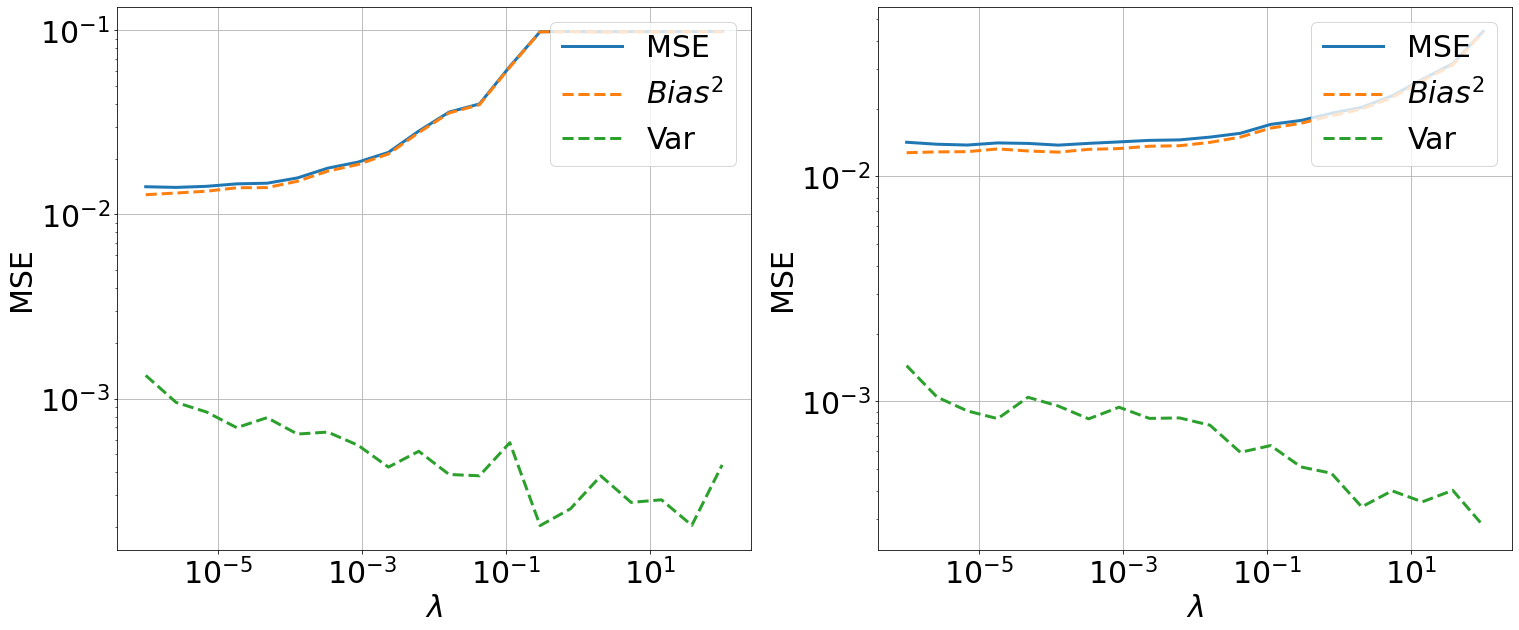

In [104]:
# Maximum polynomial order for generating the design matrix
maxpower = 5
k        = 5

# Make data using rand function
np.random.seed(2020)
n_samp = 1*int((maxpower+1)*(maxpower+2)/2)   # try it with 20
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))
xx, yy = np.meshgrid(x,y)
zz_0   = fx.FrankeFunction(xx, yy, 0)
nsig   = 0.1*np.max(np.abs(zz_0))
zz     = fx.FrankeFunction(xx, yy, nsig)

# for our computations, we reshape the Franke function to a 1D array
z = np.ravel(zz)

# Bootstrapping to evaluate bias variance trade-off
N       = 1*n_samp                            
lambdas = np.logspace(-6,2,20)
scaler  = StandardScaler()

err_lasso  = np.empty([len(lambdas)])
bi_lasso   = np.empty([len(lambdas)])
vari_lasso = np.empty([len(lambdas)])
err_ridge  = np.empty([len(lambdas)])
bi_ridge   = np.empty([len(lambdas)])
vari_ridge = np.empty([len(lambdas)])

X = fx.DesignDesign(x,y,maxpower)
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
z_test      = z_test.reshape(z_test.shape[0],1)
X_test_int  = X_test[:,0]
X_test      = X_test[:,1:]

for lamb in range(len(lambdas)):
    
    z_pred_lasso = np.empty((z_test.shape[0], N))
    z_pred_ridge = np.empty((z_test.shape[0], N))
    lasso        = Lasso(alpha = lambdas[lamb], fit_intercept=True, max_iter=10e6)
    
    for i in range(N):
    
        X_, z_    = resample(X_train, z_train)
        
        ## Scaling
        X_int = X_[:,0]
        X_    = X_[:,1:]
        scaler.fit(X_)
        X_       = scaler.transform(X_)
        X_test2  = scaler.transform(X_test)
        X_       = np.c_[X_int,X_]
        X_test2  = np.c_[X_test_int,X_test2]
            
        clf_lasso = lasso.fit(X_, z_) 
        
        z_pred_lasso[:, i]      = lasso.predict(X_test2)
        _, z_pred_ridge[:,i], _ = fx.RidgeRegression(X_,z_,X_test2,lambdas[lamb])
        
    error_lasso    = np.mean(np.mean((z_test - z_pred_lasso)**2, axis=1, keepdims=True))
    bias_lasso     = np.mean((z_test - np.mean(z_pred_lasso, axis=1, keepdims=True))**2)
    variance_lasso = np.mean(np.var(z_pred_lasso, axis=1, keepdims=True))

    error_ridge    = np.mean(np.mean((z_test - z_pred_ridge)**2, axis=1, keepdims=True))
    bias_ridge     = np.mean((z_test - np.mean(z_pred_ridge, axis=1, keepdims=True))**2)
    variance_ridge = np.mean(np.var(z_pred_ridge, axis=1, keepdims=True))
    
    err_lasso[lamb]    = error_lasso
    bi_lasso[lamb]     = bias_lasso
    vari_lasso[lamb]   = variance_lasso
    err_ridge[lamb]    = error_ridge
    bi_ridge[lamb]     = bias_ridge
    vari_ridge[lamb]   = variance_ridge
    
#################################################################################################################

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
plt.loglog(lambdas,err_lasso,linewidth=3,linestyle='-', label='MSE')
plt.loglog(lambdas,bi_lasso,linewidth=3,linestyle='--', label='$Bias^2$')
plt.loglog(lambdas,vari_lasso,linewidth=3,linestyle='--',label='Var')
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\lambda$',fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.legend()
ax.legend(loc='upper right',fontsize=30)

ax=plt.subplot(1,2,2)
plt.loglog(lambdas,err_ridge,linewidth=3,linestyle='-', label='MSE')
plt.loglog(lambdas,bi_ridge,linewidth=3,linestyle='--', label='$Bias^2$')
plt.loglog(lambdas,vari_ridge,linewidth=3,linestyle='--',label='Var')
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\lambda$',fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.legend()
ax.legend(loc='upper right',fontsize=30)
save_fig('Bias_varience_Ridge_LASSO_lambda')
plt.show()

# Optimal $\lambda$ (OLS, Ridge, and LASSO)

In [ ]:
# Maximum polynomial order for generating the design matrix
degree = 5

# Make data using rand function
np.random.seed(2020)
n_samp = 1*int((degree+1)*(degree+2)/2)   
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x[:n_test])
y_test  = np.sort(y[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)  

## Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

beta_OLS, _, _ = fx.OridinaryLeastSquares(X_train,z_train,X_test) 

lambdas    = np.logspace(-7,-3,5)   # try it wit (-9,1,11)
beta_ridge = np.empty([len(lambdas),X.shape[1]])
beta_lasso = np.empty([len(lambdas),X.shape[1]])

for lamb in range(len(lambdas)): 

    lasso                  = Lasso(alpha=lambdas[lamb], fit_intercept=False, max_iter=10e7)
    fit_lasso              = lasso.fit(X_train, z_train)
    beta_lasso[lamb,:]       = fit_lasso.coef_
    beta_ridge[lamb,:], _, _ = fx.RidgeRegression(X_train,z_train,X_test,lambdas[lamb])
    
bols = np.tile(beta_OLS,[len(lambdas),X_train.shape[1]])
fig = plt.subplots(figsize=(30,10))
ax=plt.subplot(1,3,1)
plt.semilogx(lambdas, (bols),linewidth=3)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\lambda$',fontsize=30)
plt.ylabel(r'$|\beta_i|$',fontsize=30)
plt.grid()
plt.title('OLS',fontsize=30)

ax=plt.subplot(1,3,2)
plt.semilogx(lambdas, (beta_ridge),linewidth=3)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\lambda$',fontsize=30)
plt.ylabel(r'$|\beta_i|$',fontsize=30)
plt.grid()
plt.title('Ridge',fontsize=30)

ax=plt.subplot(1,3,3)
plt.semilogx(lambdas, np.abs(beta_lasso),linewidth=3)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\lambda$',fontsize=30)
plt.ylabel(r'$|\beta_i|$',fontsize=30)
plt.title('LASSO',fontsize=30)
plt.grid()
save_fig('Optimal_beta_scaled')
plt.show()

# Confidence Interval

NameError: name 'beta_lasso' is not defined

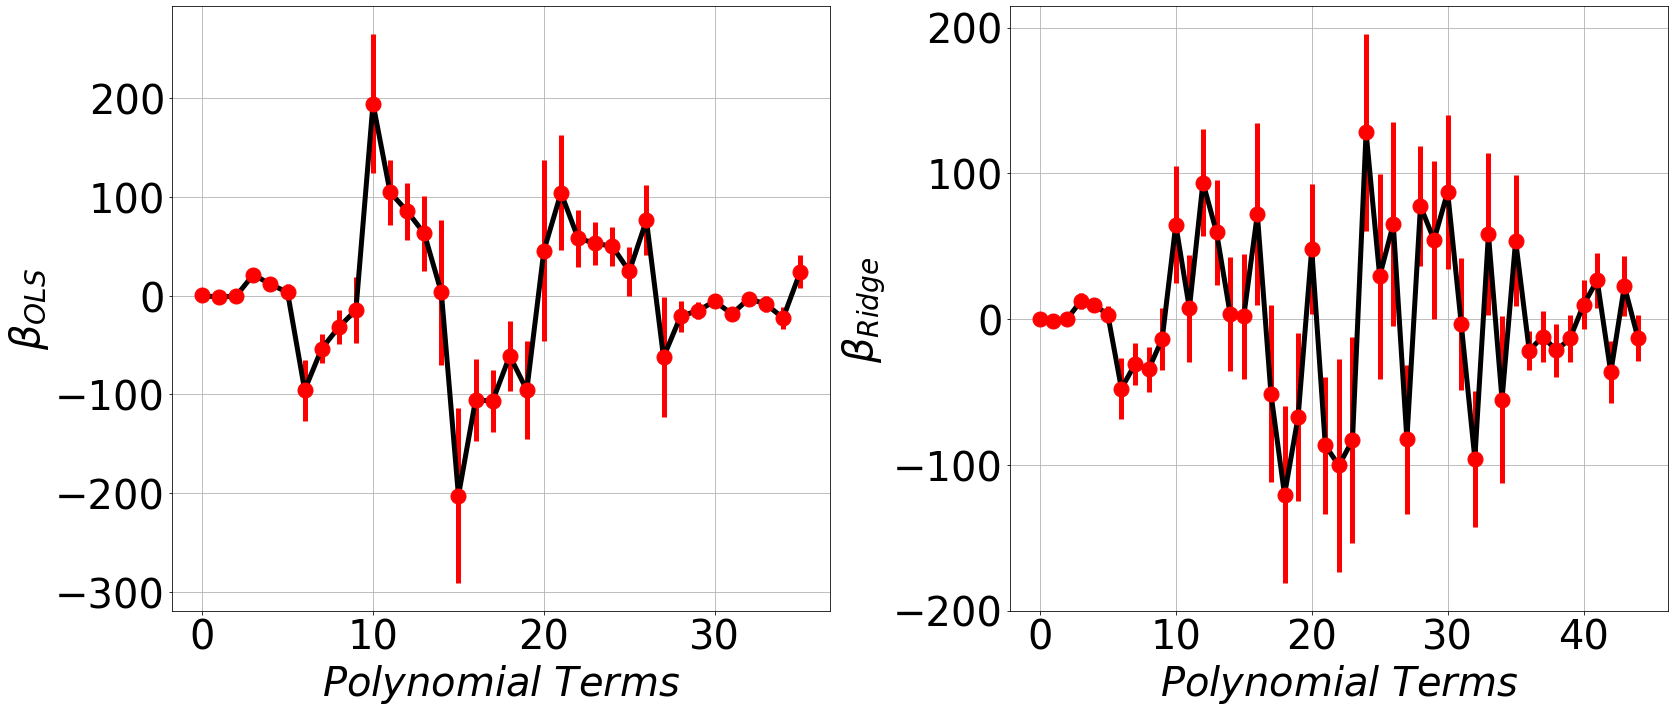

In [15]:
# Maximum polynomial order for generating the design matrix
degree_ols   = 7
degree_ridge = 8
degree_lasso = 7           
degreem      = 8

l      = int((degreem+1)*(degreem+2)/2)
n_samp = int((1*l)/0.8)
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x[:n_test])
y_test  = np.sort(y[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

_lambda  = 1e-6
_lambda2 = 1e-5

# Creating design matrix, extracting beta and predicting 
X_train_ols   = fx.DesignDesign(x_train,y_train,degree_ols)  
X_test_ols    = fx.DesignDesign(x_test,y_test,degree_ols)  
X_train_ridge = fx.DesignDesign(x_train,y_train,degree_ridge)  
X_test_ridge  = fx.DesignDesign(x_test,y_test,degree_ridge)  
X_train_lasso = fx.DesignDesign(x_train,y_train,degree_lasso)  
X_test_lasso  = fx.DesignDesign(x_test,y_test,degree_lasso)  

## Scaling OLS
scaler          = StandardScaler()
X_train_int_ols = X_train_ols[:,0]
X_test_int_ols  = X_test_ols[:,0]
X_train_ols     = X_train_ols[:,1:]
X_test_ols      = X_test_ols[:,1:]
scaler.fit(X_train_ols)
X_train_ols = scaler.transform(X_train_ols)
X_test_ols  = scaler.transform(X_test_ols)
X_train_ols = np.c_[X_train_int_ols,X_train_ols]
X_test_ols  = np.c_[X_test_int_ols,X_test_ols]

## Scaling Ridge
X_train_int_ridge = X_train_ridge[:,0]
X_test_int_ridge  = X_test_ridge[:,0]
X_train_ridge     = X_train_ridge[:,1:]
X_test_ridge      = X_test_ridge[:,1:]
scaler.fit(X_train_ridge)
X_train_ridge = scaler.transform(X_train_ridge)
X_test_ridge  = scaler.transform(X_test_ridge)
X_train_ridge = np.c_[X_train_int_ridge,X_train_ridge]
X_test_ridge  = np.c_[X_test_int_ridge,X_test_ridge]

## Scaling OLS
X_train_int_lasso = X_train_lasso[:,0]
X_test_int_lasso  = X_test_lasso[:,0]
X_train_lasso     = X_train_lasso[:,1:]
X_test_lasso      = X_test_lasso[:,1:]
scaler.fit(X_train_lasso)
X_train_lasso = scaler.transform(X_train_lasso)
X_test_lasso  = scaler.transform(X_test_lasso)
X_train_lasso = np.c_[X_train_int_lasso,X_train_lasso]
X_test_lasso  = np.c_[X_test_int_lasso,X_test_lasso]

# OLS
beta_OLS, pred_OLS_test, pred_OLS_train = fx.OridinaryLeastSquares(X_train_ols,z_train,X_test_ols) 

# confidence interval OLS
Var_beta_OLS, conf_OLS     = fx.VarianceBeta_OLS(X_train_ols,z_train,pred_OLS_train)

# Ridge
beta_Ridge, pred_Ridge_test, pred_Ridge_train = fx.RidgeRegression(X_train_ridge,z_train,X_test_ridge,_lambda) 

# confidence interval Ridge
Var_beta_Ridge, conf_Ridge = fx.VarianceBeta_Ridge(X_train_ridge,z_train,pred_Ridge_train,_lambda)

# LASSO
lasso      = Lasso(alpha = _lambda2, max_iter=10e6, fit_intercept=False)
clf_lasso  = lasso.fit(X_train_lasso, z_train) 
beta_LASSO = clf_lasso.coef_
beta_LASSO = beta_LASSO.reshape(X_train_lasso.shape[1],1)

pred_LASSO_test  = lasso.predict(X_test_lasso)
pred_LASSO_train = lasso.predict(X_train_lasso)

#---------------------- Bootstrap to calculate confidence interval of LASSO --------------

n_boostraps  = int(n_samp)
beta_LASSOb  = np.empty((X_train_lasso.shape[1], n_boostraps))

for i in range(n_boostraps):
    
    X_, z_            = resample(X_train_lasso, z_train)
    clf_lassob        = lasso.fit(X_, z_) 
    beta_LASSOb[:, i] = clf_lassob.coef_

varbeta   = np.var(beta_LASSOb, axis=1, keepdims=True)
meanbeta  = np.mean(beta_LASSOb, axis=1, keepdims=True)
conf_LSSO = 1.96*np.sqrt(varbeta)

########################### Plotting subselected data #############################

xax_ols = np.arange(0, len(beta_OLS), 1) 
fig = plt.figure(figsize=(35, 10))
ax = plt.subplot(1, 3, 1) 
plt.plot(xax_ols, beta_OLS, 'k',linewidth=5)
plt.errorbar(xax_ols, beta_OLS, yerr = conf_OLS, fmt='or',markersize=15,linewidth=5) 
plt.xlabel("$Polynomial$ $Terms$", fontsize = 40)
plt.ylabel(r"$\beta_{OLS}$", fontsize = 40)
ax.tick_params(axis='both', which='major', labelsize=40)
plt.grid()
fig.tight_layout()

xax_ridge = np.arange(0, len(beta_Ridge), 1) 
ax = plt.subplot(1, 3, 2)
plt.plot(xax_ridge, beta_Ridge, 'k',linewidth=5)
plt.errorbar(xax_ridge, beta_Ridge, yerr = conf_Ridge, fmt='or',markersize=15,linewidth=5) 
plt.xlabel("$Polynomial$ $Terms$", fontsize = 40)
plt.ylabel(r"$\beta_{Ridge}$", fontsize = 40)
ax.tick_params(axis='both', which='major', labelsize=40)
plt.grid()
fig.tight_layout()

xax_lasso = np.arange(0, len(beta_LASSO), 1) 
ax = plt.subplot(1, 3, 3) 
plt.plot(xax_lasso, beta_LASSO, 'k',linewidth=5)
plt.errorbar(xax_lasso, beta_LASSO, conf_LSSO.reshape(conf_OLS.shape), fmt='or',markersize=15,linewidth=5) 
plt.xlabel("$Polynomial$ $Terms$", fontsize = 40)
plt.ylabel(r"$\beta_{LASSO}$", fontsize = 40)
ax.tick_params(axis='both', which='major', labelsize=40)
plt.grid()
fig.tight_layout()
save_fig('Confidence_interval_scaled')
plt.show()

# Franke function analysis using OLS, Ridge, and LASSO (with optimal parameters)

Training MSE_OLS: 0.0165
Training MSE_Ridge: 0.0165
Training MSE_LASSO: 0.0170
Test MSE_OLS: 0.0177
Test MSE_Ridge: 0.0175
Test MSE_LASSO: 0.0162
Training R2_OLS: 0.8435
Training R2_Ridge: 0.8435
Training R2_LASSO: 0.8392
Test R2_OLS: 0.7773
Test R2_Ridge: 0.7795
Test R2_LASSO: 0.7969


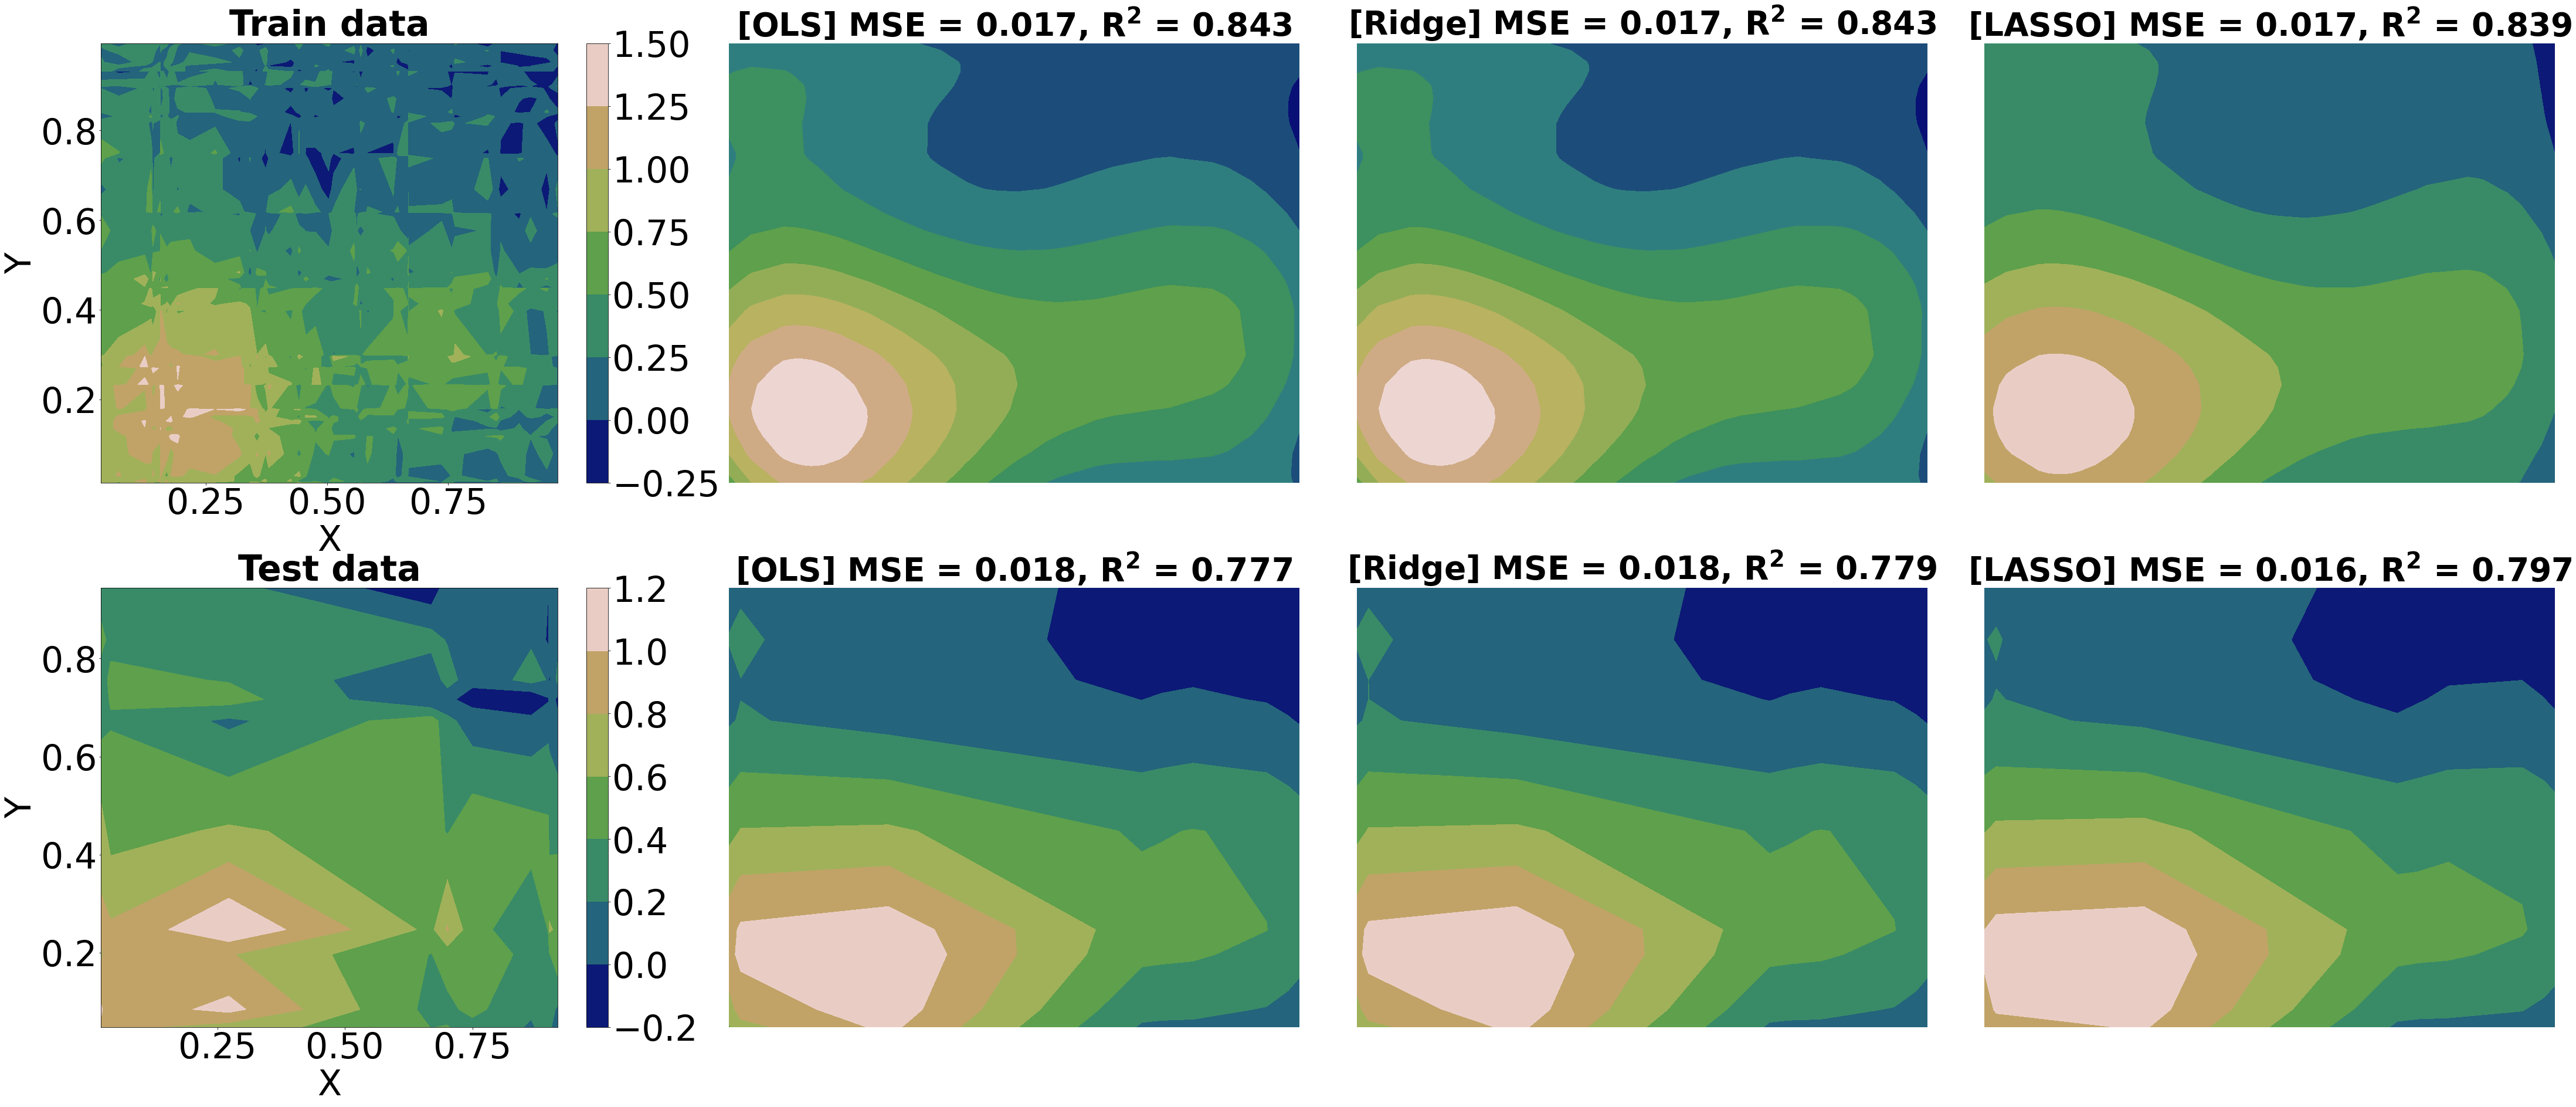

In [13]:
# Maximum polynomial order for generating the design matrix
degree_ols   = 7
degree_ridge = 8
degree_lasso = 7           
degreem      = 8

l      = int((degreem+1)*(degreem+2)/2)
n_samp = int((1*l)/0.8)
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x[:n_test])
y_test  = np.sort(y[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

_lambda  = 1e-6
_lambda2 = 1e-5

# Creating design matrix, extracting beta and predicting 
X_train_ols   = fx.DesignDesign(x_train,y_train,degree_ols)  
X_test_ols    = fx.DesignDesign(x_test,y_test,degree_ols)  
X_train_ridge = fx.DesignDesign(x_train,y_train,degree_ridge)  
X_test_ridge  = fx.DesignDesign(x_test,y_test,degree_ridge)  
X_train_lasso = fx.DesignDesign(x_train,y_train,degree_lasso)  
X_test_lasso  = fx.DesignDesign(x_test,y_test,degree_lasso)  

## Scaling OLS
scaler          = StandardScaler()
X_train_int_ols = X_train_ols[:,0]
X_test_int_ols  = X_test_ols[:,0]
X_train_ols     = X_train_ols[:,1:]
X_test_ols      = X_test_ols[:,1:]
scaler.fit(X_train_ols)
X_train_ols = scaler.transform(X_train_ols)
X_test_ols  = scaler.transform(X_test_ols)
X_train_ols = np.c_[X_train_int_ols,X_train_ols]
X_test_ols  = np.c_[X_test_int_ols,X_test_ols]

## Scaling Ridge
X_train_int_ridge = X_train_ridge[:,0]
X_test_int_ridge  = X_test_ridge[:,0]
X_train_ridge     = X_train_ridge[:,1:]
X_test_ridge      = X_test_ridge[:,1:]
scaler.fit(X_train_ridge)
X_train_ridge = scaler.transform(X_train_ridge)
X_test_ridge  = scaler.transform(X_test_ridge)
X_train_ridge = np.c_[X_train_int_ridge,X_train_ridge]
X_test_ridge  = np.c_[X_test_int_ridge,X_test_ridge]

## Scaling OLS
X_train_int_lasso = X_train_lasso[:,0]
X_test_int_lasso  = X_test_lasso[:,0]
X_train_lasso     = X_train_lasso[:,1:]
X_test_lasso      = X_test_lasso[:,1:]
scaler.fit(X_train_lasso)
X_train_lasso = scaler.transform(X_train_lasso)
X_test_lasso  = scaler.transform(X_test_lasso)
X_train_lasso = np.c_[X_train_int_lasso,X_train_lasso]
X_test_lasso  = np.c_[X_test_int_lasso,X_test_lasso]

# OLS
_, pred_OLS_test, pred_OLS_train = fx.OridinaryLeastSquares(X_train_ols,z_train,X_test_ols) 

# Ridge
_, pred_Ridge_test, pred_Ridge_train = fx.RidgeRegression(X_train_ridge,z_train,X_test_ridge,_lambda) 

# LASSO
lasso      = Lasso(alpha = _lambda2, max_iter=10e6, fit_intercept=False)
clf_lasso  = lasso.fit(X_train_lasso, z_train) 
beta_LASSO = beta_LASSO.reshape(X_train_lasso.shape[1],1)

pred_LASSO_test  = lasso.predict(X_test_lasso)
pred_LASSO_train = lasso.predict(X_train_lasso)

# MSE and R2
MSE_OLS_test  = fx.MSE(z_test,pred_OLS_test)
MSE_OLS_train = fx.MSE(z_train,pred_OLS_train)
R2_OLS_test   = fx.R2Score(z_test,pred_OLS_test)
R2_OLS_train  = fx.R2Score(z_train,pred_OLS_train)
    
MSE_Ridge_test  = fx.MSE(z_test,pred_Ridge_test)
MSE_Ridge_train = fx.MSE(z_train,pred_Ridge_train)
R2_Ridge_test   = fx.R2Score(z_test,pred_Ridge_test)
R2_Ridge_train  = fx.R2Score(z_train,pred_Ridge_train)

MSE_LASSO_test  = fx.MSE(z_test,pred_LASSO_test)
MSE_LASSO_train = fx.MSE(z_train,pred_LASSO_train)
R2_LASSO_test   = fx.R2Score(z_test,pred_LASSO_test)
R2_LASSO_train  = fx.R2Score(z_train,pred_LASSO_train)
        
# Plot the resulting fit beside the original surface
ppred_OLS_test  = pred_OLS_test.reshape(xx_test.shape)
ppred_OLS_train = pred_OLS_train.reshape(xx_train.shape)

ppred_Ridge_test  = pred_Ridge_test.reshape(xx_test.shape)
ppred_Ridge_train = pred_Ridge_train.reshape(xx_train.shape)        

ppred_LASSO_test  = pred_LASSO_test.reshape(xx_test.shape)
ppred_LASSO_train = pred_LASSO_train.reshape(xx_train.shape)

print("Training MSE_OLS: %0.4f" % MSE_OLS_train)
print("Training MSE_Ridge: %0.4f" % MSE_Ridge_train)
print("Training MSE_LASSO: %0.4f" % MSE_LASSO_train)

print("Test MSE_OLS: %0.4f" % MSE_OLS_test)
print("Test MSE_Ridge: %0.4f" % MSE_Ridge_test)
print("Test MSE_LASSO: %0.4f" % MSE_LASSO_test)

print("Training R2_OLS: %0.4f" % R2_OLS_train)
print("Training R2_Ridge: %0.4f" % R2_Ridge_train)
print("Training R2_LASSO: %0.4f" % R2_LASSO_train)

print("Test R2_OLS: %0.4f" % R2_OLS_test)
print("Test R2_Ridge: %0.4f" % R2_Ridge_test)
print("Test R2_LASSO: %0.4f" % R2_LASSO_test)

########################### Plotting subselected data #############################

fig  = plt.figure(figsize=(75, 65))
ax =plt.subplot(4, 4, 1)
figure1=plt.contourf(x_train,y_train,zz_train, cmap='gist_earth')
plt.title('Train data', fontsize=60, fontweight='bold')
plt.xlabel('X', fontsize=60)
plt.ylabel('Y', fontsize=60)
ax.tick_params(axis='both', which='major', labelsize=60)
cbar=fig.colorbar(figure1)
cbar.ax.tick_params(labelsize=60)
#fig.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.24)

ax=plt.subplot(4, 4, 2)
figure2=plt.contourf(x_train,y_train,ppred_OLS_train, cmap='gist_earth')
plt.title("[OLS]"+" MSE = %0.3f" %MSE_OLS_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_train, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 3)
figure3=plt.contourf(x_train,y_train,ppred_Ridge_train, cmap='gist_earth')
plt.title("[Ridge]"+" MSE = %0.3f" %MSE_Ridge_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_train, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 4)
figure4=plt.contourf(x_train,y_train,ppred_LASSO_train, cmap='gist_earth')
plt.title("[LASSO]"+" MSE = %0.3f" %MSE_LASSO_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_train, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

#plt.subplots(figsize=(15, 5))
ax = plt.subplot(4, 4, 5)
figure3=plt.contourf(x_test,y_test,zz_test, cmap='gist_earth')
plt.title('Test data', fontsize=60, fontweight='bold')
plt.xlabel('X', fontsize=60)
plt.ylabel('Y', fontsize=60)
ax.tick_params(axis='both', which='major', labelsize=60)
cbar=fig.colorbar(figure3)
cbar.ax.tick_params(labelsize=60)
#fig.tight_layout()
#plt.axis('off')

ax=plt.subplot(4, 4, 6)
figure4=plt.contourf(x_test,y_test,ppred_OLS_test, cmap='gist_earth')
plt.title("[OLS]"+" MSE = %0.3f" %MSE_OLS_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_test, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 7)
figure4=plt.contourf(x_test,y_test,ppred_Ridge_test, cmap='gist_earth')
plt.title("[Ridge]"+" MSE = %0.3f" %MSE_Ridge_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_test, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 8)
figure4=plt.contourf(x_test,y_test,ppred_LASSO_test, cmap='gist_earth')
plt.title("[LASSO]"+" MSE = %0.3f" %MSE_LASSO_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_test, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')
save_fig('OLS_Ridge_LASSO_degree8')
plt.show()